# **Classification d'images de planètes et lunes en utilisant les Arbres de Décision (DT) et les Forêts Aléatoires (RF).**


# **1. Importation des modules Python et du Dataset**

In [20]:
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, top_k_accuracy_score, precision_recall_curve
import pandas as pd
import progressbar
import kagglehub
import os
import time
import progressbar
import matplotlib.pyplot as plt


In [21]:
import kagglehub

# Téléchargement de la dernière version du dataset "Planets and Moons"
path = kagglehub.dataset_download("emirhanai/planets-and-moons-dataset-ai-in-space")

__builtins__.print("Chemin vers les fichiers du dataset :", path)

Using Colab cache for faster access to the 'planets-and-moons-dataset-ai-in-space' dataset.
Chemin vers les fichiers du dataset : /kaggle/input/planets-and-moons-dataset-ai-in-space


# **2. Chargement et Prétraitement des données**

In [22]:
import os
from pathlib import Path

root = Path(path)
img_root = root / 'Planets_Moons_Data' / 'Planets and Moons'

# Vérification de l'existence du dossier et affichage des premiers fichiers
__builtins__.print("img_root exists?", img_root.exists())

# Définition des extensions d'images autorisée
IMG_EXT = {".jpg",".jpeg",".png",".bmp",".webp"}

img_root exists? True


In [23]:
def load_samples(img_root: Path):
  # Parcourt les dossiers pour récupérer les chemins d'images et leurs étiquettes
    samples = []
    for img_path in img_root.rglob("*"):
        if img_path.suffix.lower() in IMG_EXT:
            label = img_path.parent.name  # ex: Papaya, Banana...
            samples.append((str(img_path), label))
    return samples

# Listes des classes = ['Moon', 'Jupiter', 'Uranus', 'Pluto', 'Earth', 'Mars', 'Venus', 'Saturn', 'MakeMake', 'Neptune', 'Mercury']
samples = load_samples(img_root)
# Chargement initial et filtrage des classes spécifiques
allowed_classes = ['Earth', 'Neptune', 'Mars', 'Jupiter', 'Pluto', 'Venus']
samples = [(img_path, label) for img_path, label in samples if label in allowed_classes]

__builtins__.print("Nb images:", len(samples))
__builtins__.print("Nb classes:", len(set(lbl for _, lbl in samples)))

Nb images: 894
Nb classes: 6


# **3. Classes du Dataset**

In [24]:
class Dataset:
  def __init__(self, samples_list, size=0):
    if size == 0 or size > len(samples_list):
      size = len(samples_list)
    self.length = size
    self.data = [s[0] for s in samples_list[:size]]  # Chemins des images
    self.targets = [s[1] for s in samples_list[:size]] # Étiquettes
    self.X_train, self.X_test, self.y_train, self.y_test = [], [], [], []

  def separate_train_test(self, test_size_ratio):
    # Divise les données en ensembles d'entraînement et de test
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        self.data, self.targets, test_size=test_size_ratio, random_state=42, stratify=self.targets)
    __builtins__.print('Size of training set : ' + str(len(self.y_train)) + ' / ' + str(len(self.data)));
    __builtins__.print('Size of testing set : ' + str(len(self.y_test))+ ' / ' + str(len(self.data)));

    return self.X_train, self.X_test, self.y_train, self.y_test # Added return statement

Data_set = Dataset(samples,len(samples))
X_train_paths, X_test_paths, y_train_labels, y_test_labels = Data_set.separate_train_test(0.2);

Size of training set : 715 / 894
Size of testing set : 179 / 894


# **4. Definition de la fonctions d'extration**

In [25]:
import cv2
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, hog

def get_lbp_histogram(gray_img):
    """Extraction de la texture fine (Grains) (Grain)"""
    P, R = 8, 1
    lbp = local_binary_pattern(gray_img, P, R, method="uniform")
    # Fix n_bins to a constant value for uniform LBP (P=8, R=1 -> 10 unique patterns 0-9)
    n_bins = P + 2 # For 'uniform' LBP, this is the number of possible distinct patterns (0 to P+1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist

def get_color_histogram(img):
    """Extraction de la distribution des couleurs"""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1], None, [8, 8], [0, 180, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def get_hog_features(gray_img):
    """Extraction des formes et contours"""
    hog_feat = hog(gray_img, orientations=9, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)
    return hog_feat

def extract_features(img_path, size=(128, 128)):
    """Fonction principale pour combiner les différentes caractéristiques d'une image"""
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Choix des caractéristiques à fusionner
    feat_color    = get_color_histogram(img)
    feat_lbp      = get_lbp_histogram(gray)
    feat_hog      = get_hog_features(gray)

    final_features = np.concatenate([feat_color, feat_lbp, feat_hog])

    return final_features.astype(np.float32)

# **5. Modèle Decision Tree (Arbre de Décision)**

100% (9 of 9) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04


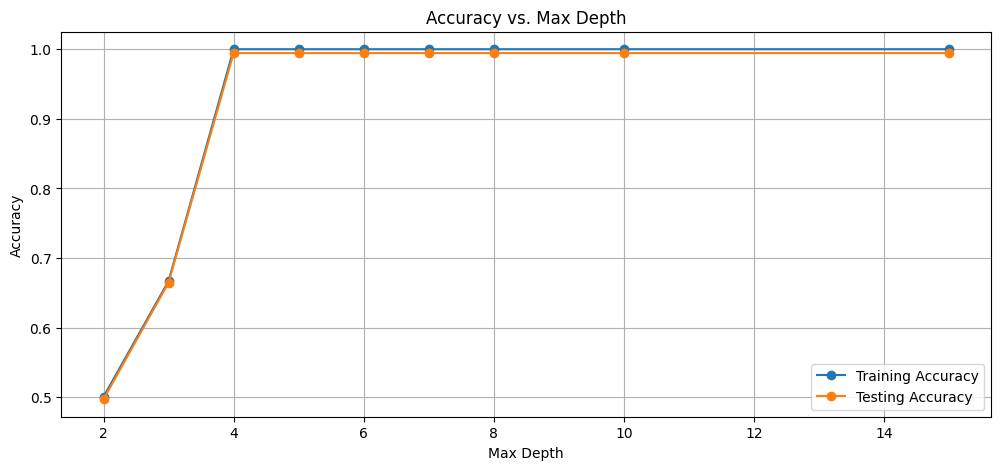

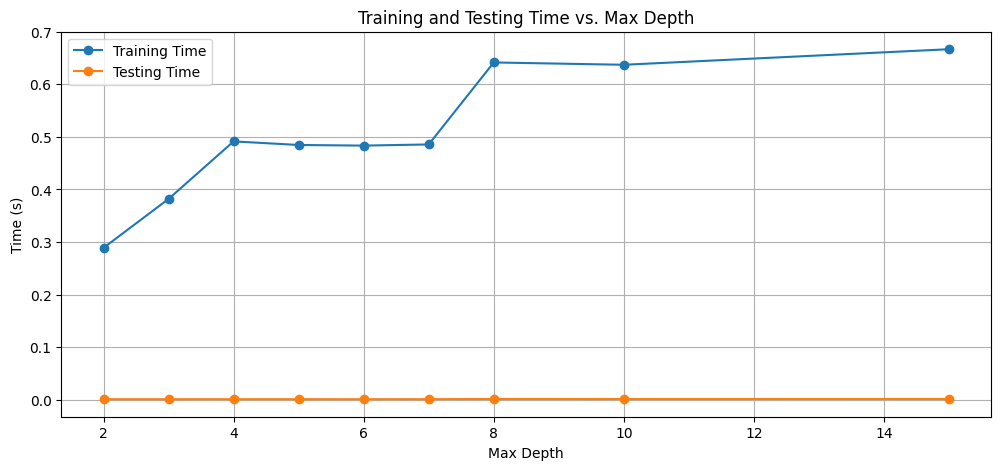

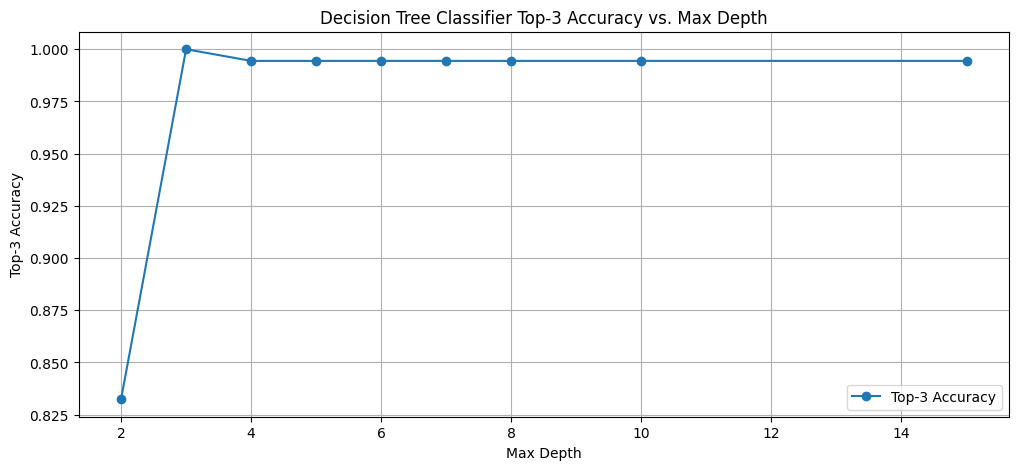

Depths tested: [2, 3, 4, 5, 6, 7, 8, 10, 15]
Accuracies training: [0.5006993006993007, 0.6671328671328671, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Accuracies testing: [0.4972067039106145, 0.664804469273743, 0.994413407821229, 0.994413407821229, 0.994413407821229, 0.994413407821229, 0.994413407821229, 0.994413407821229, 0.994413407821229]
Top-3 Accuracies: [np.float64(0.8324022346368715), np.float64(1.0), np.float64(0.994413407821229), np.float64(0.994413407821229), np.float64(0.994413407821229), np.float64(0.994413407821229), np.float64(0.994413407821229), np.float64(0.994413407821229), np.float64(0.994413407821229)]


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

depths = [2,3,4,5,6,7,8,10,15]
top_k_accuracies_dt = []
k_value = 3
# Préparation des vecteurs de caractéristiques
score_training = [0.0 for i in range(len(depths))]
score_testing  = [0.0 for i in range(len(depths))]
time_train  = [0.0 for i in range(len(depths))]
time_test  = [0.0 for i in range(len(depths))]
idx=0;
#Critère à valider : Accuracy, Top-K accuracy, Confusion Matrix, Precision & Recall , Precision-Recall curve, F-measure

# --- Traitement des données d'entraînement ---
# Collecte des caractéristiques et des étiquettes correspondantes, en filtrant les extractions échouées
processed_train_data = []
for i, p in enumerate(X_train_paths):
    features = extract_features(p)
    if features is not None:
        processed_train_data.append((features, y_train_labels[i]))

# Séparation des caractéristiques et des étiquettes pour l'entraînemen
X_train_features = np.array([item[0] for item in processed_train_data])
y_train_labels_filtered = [item[1] for item in processed_train_data]

# Encodage des étiquettes d'entraînements
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_labels_filtered)

# --- Traitement des données de test ---
# Collecte des caractéristiques et des étiquettes correspondantes, en filtrant les extractions échouées
processed_test_data = []
for i, p in enumerate(X_test_paths):
    features = extract_features(p)
    if features is not None:
        processed_test_data.append((features, y_test_labels[i]))

# Séparation des caractéristiques et des étiquettes pour le test
X_test_features = np.array([item[0] for item in processed_test_data])
y_test_labels_filtered = [item[1] for item in processed_test_data]

# Encodage des étiquettes de test en utilisant le même encodeur ajusté sur les données d'entraînement
y_test_encoded = label_encoder.transform(y_test_labels_filtered)

bar = progressbar.ProgressBar(maxval=len(depths)).start()

# Boucle de test sur différentes profondeurs d'arbre
for d in depths:
    # Initialisation du classificateur
    clf = DecisionTreeClassifier(random_state=0, max_depth=d)

    # Temps d'entraînement
    tic = time.time()
    clf.fit(X_train_features, y_train_encoded)
    tac = time.time()
    time_train[idx] = tac - tic

    # Score d'entraînement
    score_training[idx] = clf.score(X_train_features, y_train_encoded)

    # Temps de test
    tic = time.time()
    score_testing[idx] = clf.score(X_test_features, y_test_encoded)
    tac = time.time()
    time_test[idx] = tac - tic

    # Prédire les probabilités sur l'ensemble de test
    y_pred_proba_dt = clf.predict_proba(X_test_features)

    # Calculer le Top-K accuracy
    top_k_acc_dt = top_k_accuracy_score(y_test_encoded, y_pred_proba_dt, k=k_value)
    top_k_accuracies_dt.append(top_k_acc_dt)

    idx += 1
    bar.update(idx)

bar.finish()

# Visualisation des résultats
plt.figure(figsize=(12, 5))

# Créer la Figure 1 : Précision du test
plt.plot(depths, score_training, label='Training Accuracy', marker='o')
plt.plot(depths, score_testing, label='Testing Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Max Depth')
plt.legend()
plt.grid(True)

# Créer la Figure 2 : Temps d'entraînement
plt.figure(figsize=(12, 5))
plt.plot(depths, time_train, label='Training Time', marker='o')
plt.plot(depths, time_test, label='Testing Time', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Time (s)')
plt.title('Training and Testing Time vs. Max Depth')
plt.legend()
plt.grid(True)

# Créer la Figure 3 : Top-K Accuracy
plt.figure(figsize=(12, 5))
plt.plot(depths, top_k_accuracies_dt, label=f'Top-{k_value} Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel(f'Top-{k_value} Accuracy')
plt.title(f'Decision Tree Classifier Top-{k_value} Accuracy vs. Max Depth')
plt.legend()
plt.grid(True)
plt.show()

__builtins__.print(f"Depths tested: {depths}")
__builtins__.print(f"Accuracies training: {score_training}")
__builtins__.print(f"Accuracies testing: {score_testing}")
__builtins__.print(f"Top-{k_value} Accuracies: {top_k_accuracies_dt}")



## **5.1. Validation Croisée et Analyse des Features**

### **5.1.1. Pour tout les features**

Accuracy on training set= 1.0
[1. 1. 1. 1. 1.]
Accuracy: 1.00 (CI : +/- 0.00)
Accuracy on test set= 0.9944


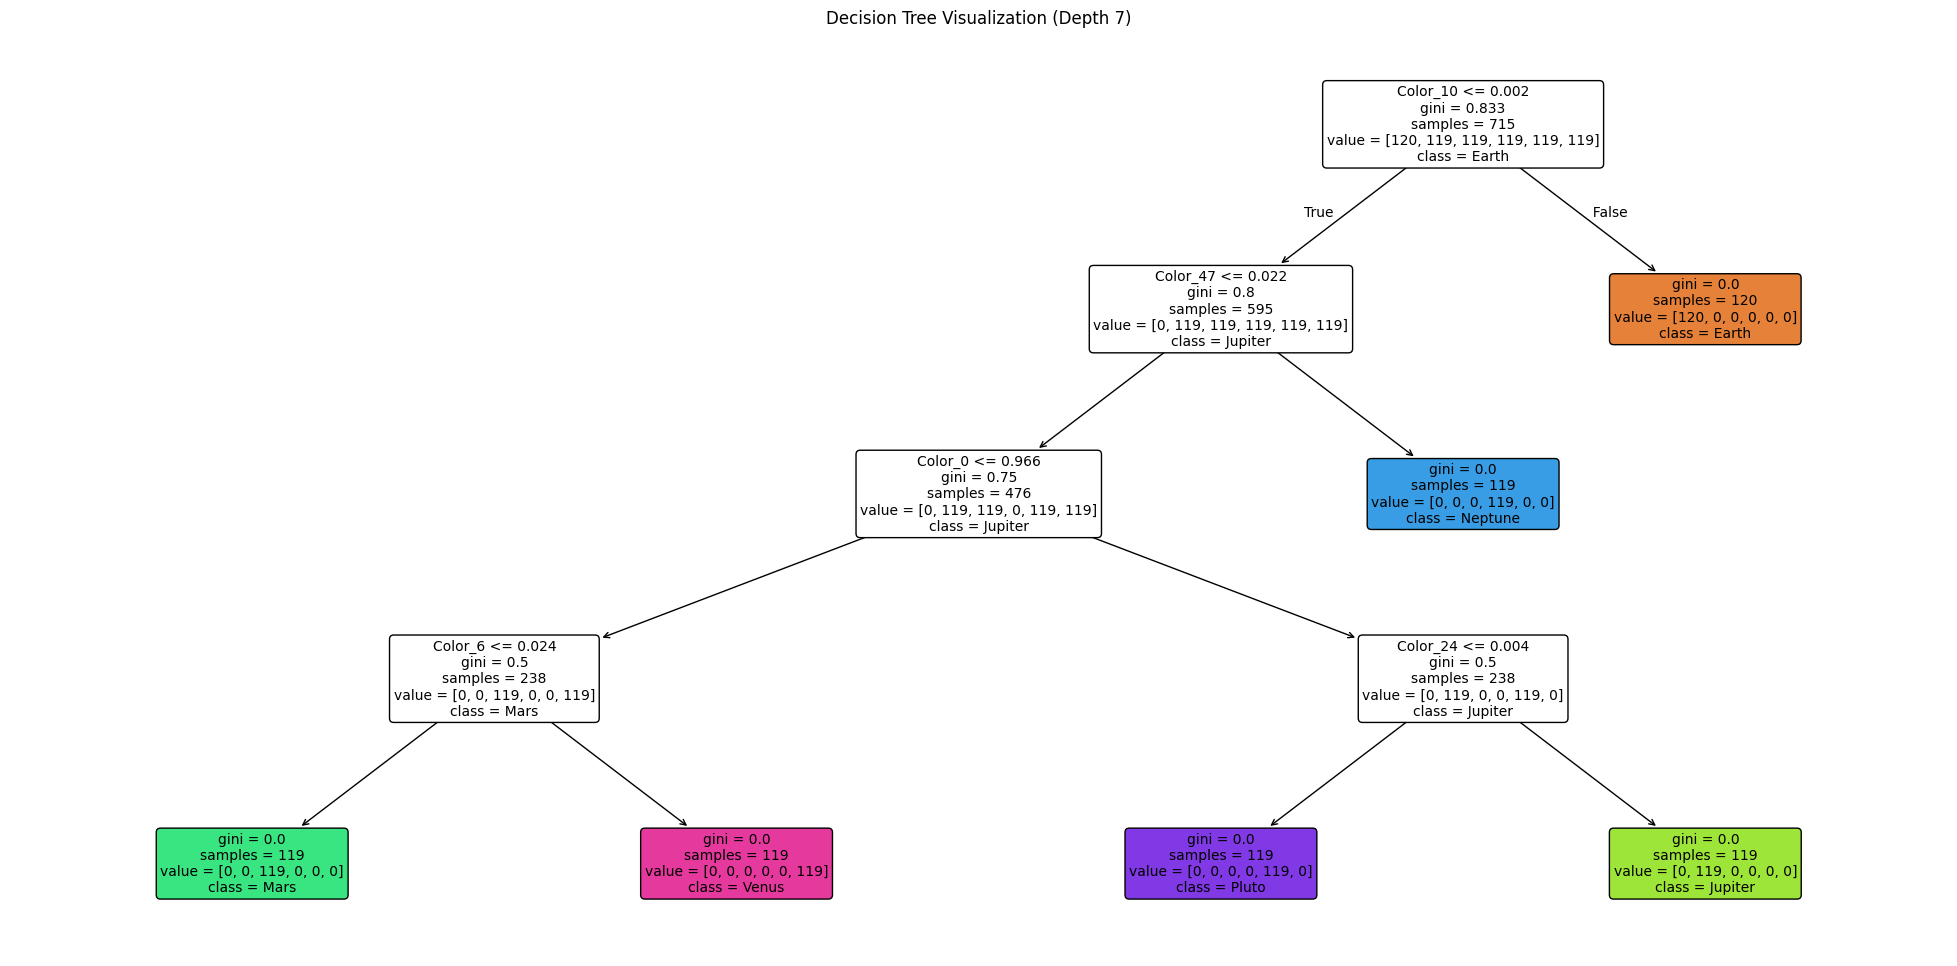

       Feature  Importance
10    Color_10    0.201117
24    Color_24    0.199721
47    Color_47    0.199721
6      Color_6    0.199721
0      Color_0    0.199721
1233  Hog_1159    0.000000
1232  Hog_1158    0.000000
1231  Hog_1157    0.000000
1230  Hog_1156    0.000000
1229  Hog_1155    0.000000


In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

# Flag pour l'analyse de feature en fonction de extract_feature
all_flag = True;
lbp_flag = False;
rgb_flag = False;
hog_flag = False;

if all_flag:
  best_depth = 7
  k = 5
  clf = DecisionTreeClassifier(random_state=0, max_depth=best_depth)
  clf.fit(X_train_features, y_train_encoded)
  print ('Accuracy on training set= ' +  str(round(clf.score(X_train_features, y_train_encoded),4)));
  scores = cross_val_score(clf, X_train_features, y_train_encoded, cv=k, scoring='accuracy')
  print (scores)
  print("Accuracy: %0.2f (CI : +/- %0.2f)" % (scores.mean(), scores.std() * 4))
  print ('Accuracy on test set= ' +  str(round(clf.score(X_test_features, y_test_encoded),4)));

  # Obtenir le nombre de fonctionnalités pour chaque type basé sur la fonction extract_features
  num_color_features = 64
  num_lbp_features = 10
  # Calculer les fonctionnalités HOG dynamiquement ou basé sur les paramètres standards
  num_hog_features = X_train_features.shape[1] - num_color_features - num_lbp_features

  color_names = [f'Color_{i}' for i in range(num_color_features)]
  lbp_names = [f'LBP_{i}' for i in range(num_lbp_features)]
  hog_names = [f'Hog_{i}' for i in range(num_hog_features)]

  feature_names_list = color_names + lbp_names + hog_names

  # --- VISUALISATION ---
  plt.figure(figsize=(25, 12))

  plot_tree(clf,
            filled=True,
            rounded=True,
            feature_names=feature_names_list,
            class_names = list(label_encoder.classes_),
            fontsize=10)

  plt.title(f"Decision Tree Visualization (Depth {best_depth})")
  plt.show()

  # --- IMPORTANCE DES FEATURES ---
  importances = pd.DataFrame({
      'Feature': feature_names_list,
      'Importance': clf.feature_importances_
  })

  # Afficher les 10 fonctionnalités les plus importantes
  print(importances.sort_values(by='Importance', ascending=False).head(10))

### **5.1.2. Pour RGB**

In [28]:
if rgb_flag:
  best_depth = 4
  k = 5
  clf = DecisionTreeClassifier(random_state=0, max_depth=best_depth)
  clf.fit(X_train_features, y_train_encoded)
  print ('Accuracy on training set= ' +  str(round(clf.score(X_train_features, y_train_encoded),4)));
  scores = cross_val_score(clf, X_train_features, y_train_encoded, cv=k, scoring='accuracy')
  print (scores)
  print("Accuracy: %0.2f (CI : +/- %0.2f)" % (scores.mean(), scores.std() * 4))
  print ('Accuracy on test set= ' +  str(round(clf.score(X_test_features, y_test_encoded),4)));

  color_names = [f'Color_{i}' for i in range(X_train_features.shape[1])] # Obtenir dynamiquement le nombre de features

  feature_names_list = color_names

  # --- VISUALISATION ---
  plt.figure(figsize=(25, 12))

  plot_tree(clf,
            filled=True,
            rounded=True,
            feature_names=feature_names_list,
            class_names = list(label_encoder.classes_),
            fontsize=10)

  plt.title(f"Decision Tree Visualization (Depth {best_depth})")
  plt.show()

  # --- IMPORTANCE DES FEATURES ---
  importances = pd.DataFrame({
      'Feature': feature_names_list,
      'Importance': clf.feature_importances_
  })

  # Afficher les 10 fonctionnalités les plus importantes
  print(importances.sort_values(by='Importance', ascending=False).head(10))

### **5.1.3. Pour HOG**

In [29]:
if hog_flag:
  best_depth = 6
  k = 5
  clf = DecisionTreeClassifier(random_state=0, max_depth=best_depth)
  clf.fit(X_train_features, y_train_encoded)
  print ('Accuracy on training set= ' +  str(round(clf.score(X_train_features, y_train_encoded),4)));
  scores = cross_val_score(clf, X_train_features, y_train_encoded, cv=k, scoring='accuracy')
  print (scores)
  print("Accuracy: %0.2f (CI : +/- %0.2f)" % (scores.mean(), scores.std() * 4))
  print ('Accuracy on test set= ' +  str(round(clf.score(X_test_features, y_test_encoded),4)));

  hog_names = [f'HOG_{i}' for i in range(X_train_features.shape[1])] # Obtenir dynamiquement le nombre de features

  feature_names_list = hog_names

  # --- VISUALISATION ---
  plt.figure(figsize=(25, 12))

  plot_tree(clf,
            filled=True,
            rounded=True,
            feature_names=feature_names_list,  # <--- Pass the list here
            class_names = list(label_encoder.classes_),
            fontsize=10)

  plt.title(f"Decision Tree Visualization (Depth {best_depth})")
  plt.show()

  # --- IMPORTANCE DES FEATURES ---
  importances = pd.DataFrame({
      'Feature': feature_names_list,
      'Importance': clf.feature_importances_
  })

  # Afficher les 10 fonctionnalités les plus importantes
  print(importances.sort_values(by='Importance', ascending=False).head(10))

### **5.1.4. Pour LGB**

In [30]:
if lbp_flag:
  best_depth = 7
  k = 5
  clf = DecisionTreeClassifier(random_state=0, max_depth=best_depth)
  clf.fit(X_train_features, y_train_encoded)
  print ('Accuracy on training set= ' +  str(round(clf.score(X_train_features, y_train_encoded),4)));
  scores = cross_val_score(clf, X_train_features, y_train_encoded, cv=k, scoring='accuracy')
  print (scores)
  print("Accuracy: %0.2f (CI : +/- %0.2f)" % (scores.mean(), scores.std() * 4))
  print ('Accuracy on test set= ' +  str(round(clf.score(X_test_features, y_test_encoded),4)));

  lbp_names = [f'LBP_{i}' for i in range(10)] # Longueur 10

  feature_names_list = lbp_names

  # --- VISUALISATION ---
  plt.figure(figsize=(25, 12))

  plot_tree(clf,
            filled=True,
            rounded=True,
            feature_names=feature_names_list,
            class_names = list(label_encoder.classes_),
            fontsize=10)

  plt.title(f"Decision Tree Visualization (Depth {best_depth})")
  plt.show()

  # --- IMPORTANCE DES FEATURES ---
  importances = pd.DataFrame({
      'Feature': feature_names_list,
      'Importance': clf.feature_importances_
  })

  # Afficher les 10 fonctionnalités les plus importantes
  print(importances.sort_values(by='Importance', ascending=False).head(10))

## **5.2. Matrice de Confusion**

In [31]:
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap('Blues')
  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
      plt.text(j, i, "{:0.3f}".format(cm[i, j]),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")
    else:
      plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

<Figure size 1000x600 with 0 Axes>

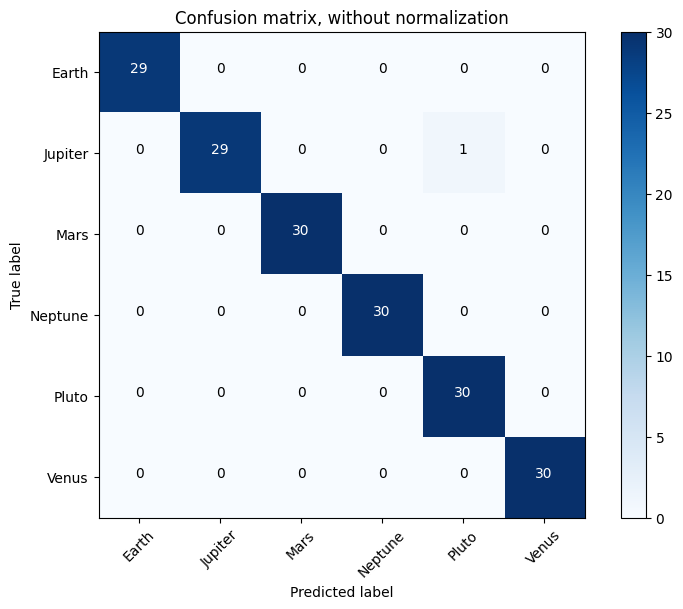

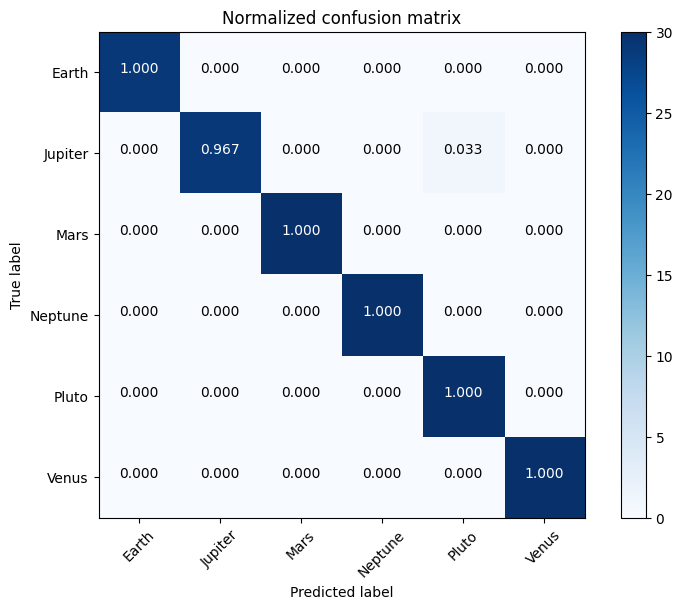

In [32]:
# Tracer la matrice de confusion non normalisée
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


le_for_class_names = LabelEncoder()
# Ajuster sur toutes les étiquettes originales (train + test) pour avoir toutes les classes uniques
le_for_class_names.fit(y_train_labels + y_test_labels)
class_names = list(le_for_class_names.classes_)

titles_options = [("Confusion matrix, without normalization", False),
                  ("Normalized confusion matrix", True)]

# Faire des prédictions en utilisant le classificateur entraîné 'clf' et les features du set de test
y_hat_encoded = clf.predict(X_test_features);

# La confusion_matrix attend les vraies étiquettes et les étiquettes prédites
# y_test_encoded contient les vraies étiquettes, encodées numériquement
# y_hat_encoded contient les étiquettes prédites, encodées numériquement par clf.predict
conf_mx = confusion_matrix(y_test_encoded, y_hat_encoded)

plt.figure(figsize=(10,6))
for title, normalize in titles_options:
    disp = plot_confusion_matrix(cm=conf_mx,
                                 target_names=class_names,
                                 title=title,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)

## 5.3. Affichage de la Précision et du Rappel (Precision & Recall)

In [33]:
from sklearn.metrics import classification_report

# Faire des prédictions sur le set de test
y_pred_encoded = clf.predict(X_test_features)
class_names = label_encoder.classes_

# Générer et afficher le rapport de classification
__builtins__.print("Classification Report:")
__builtins__.print(classification_report(y_test_encoded, y_pred_encoded, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       Earth       1.00      1.00      1.00        29
     Jupiter       1.00      0.97      0.98        30
        Mars       1.00      1.00      1.00        30
     Neptune       1.00      1.00      1.00        30
       Pluto       0.97      1.00      0.98        30
       Venus       1.00      1.00      1.00        30

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179



## 5.4. Affichage de la courbe Précision-Rappel (Precision-Recall Curve)

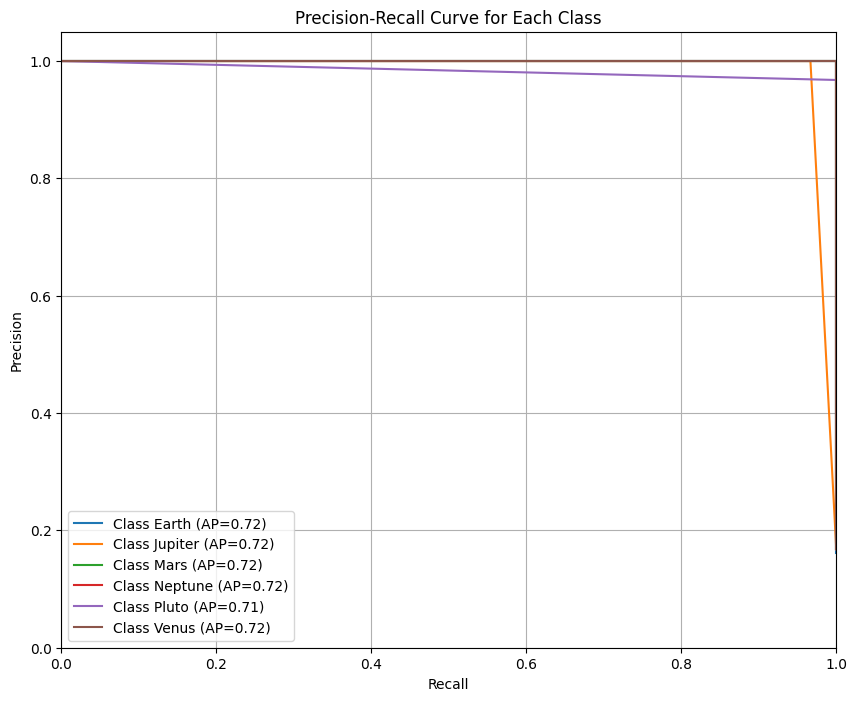

In [34]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import LabelBinarizer

# Obtenir les probabilités de prédiction pour le set de test
y_pred_proba = clf.predict_proba(X_test_features)

binarizer = LabelBinarizer()
binarizer.fit(label_encoder.transform(label_encoder.classes_))
y_test_binarized = binarizer.transform(y_test_encoded)

class_names = label_encoder.classes_
n_classes = len(class_names)

# Tracer la courbe Précision-Rappel pour chaque classe
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    y_true_class = y_test_binarized[:, i]
    y_score_class = y_pred_proba[:, i]

    precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)

    plt.plot(recall, precision, label=f'Class {class_names[i]} (AP={np.mean(precision):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

# **6. Modèle Random Forest (Forêt Aléatoire)**

100% (9 of 9) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 9) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Number of trees: 1
Number of trees: 10


100% (9 of 9) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
 11% (1 of 9) |##                        | Elapsed Time: 0:00:00 ETA:   0:00:01

Number of trees: 20


100% (9 of 9) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02
  0% (0 of 9) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Number of trees: 30


100% (9 of 9) |##########################| Elapsed Time: 0:00:03 Time:  0:00:03
  0% (0 of 9) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Number of trees: 40


100% (9 of 9) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04


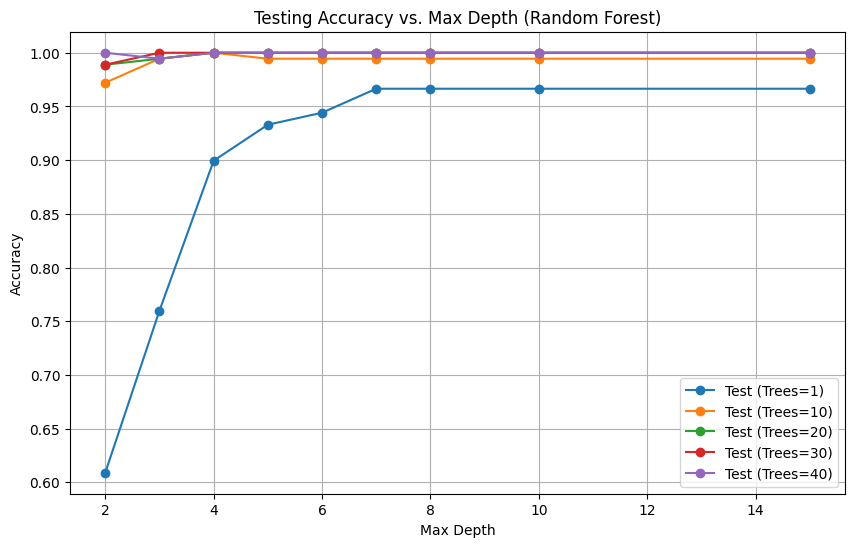

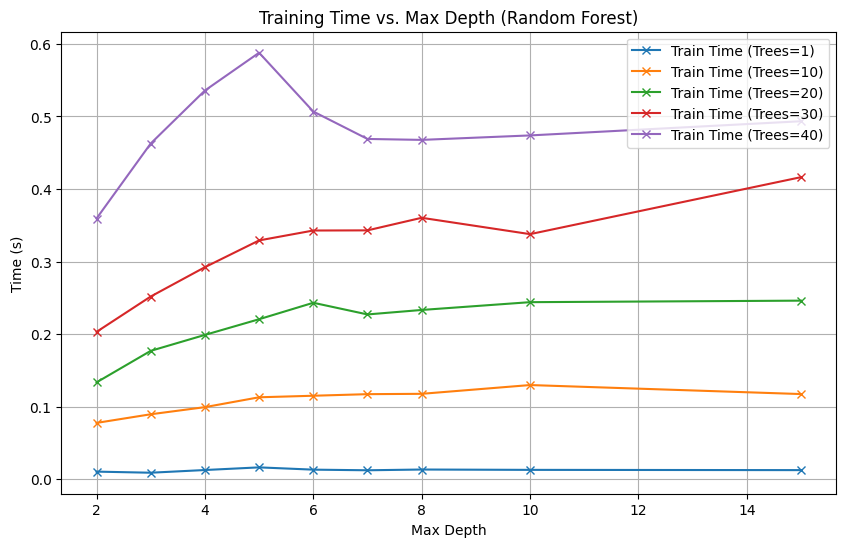

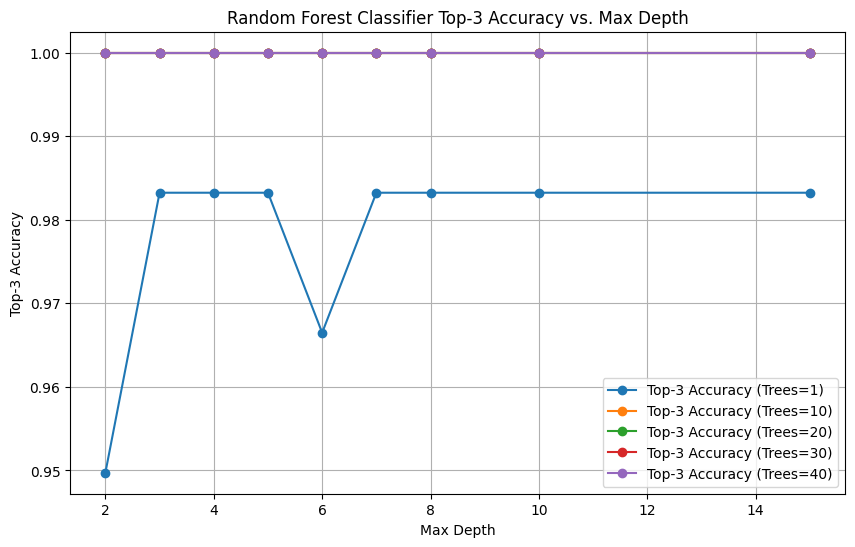

Tree tested: 1
Depths tested: [2, 3, 4, 5, 6, 7, 8, 10, 15]
Accuracies training: [0.6089385474860335, 0.7597765363128491, 0.8994413407821229, 0.9329608938547486, 0.9441340782122905, 0.9664804469273743, 0.9664804469273743, 0.9664804469273743, 0.9664804469273743]
Tree tested: 10
Depths tested: [2, 3, 4, 5, 6, 7, 8, 10, 15]
Accuracies training: [0.9720670391061452, 0.994413407821229, 1.0, 0.994413407821229, 0.994413407821229, 0.994413407821229, 0.994413407821229, 0.994413407821229, 0.994413407821229]
Tree tested: 20
Depths tested: [2, 3, 4, 5, 6, 7, 8, 10, 15]
Accuracies training: [0.9888268156424581, 0.994413407821229, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Tree tested: 30
Depths tested: [2, 3, 4, 5, 6, 7, 8, 10, 15]
Accuracies training: [0.9888268156424581, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Tree tested: 40
Depths tested: [2, 3, 4, 5, 6, 7, 8, 10, 15]
Accuracies training: [1.0, 0.994413407821229, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [35]:
from sklearn.ensemble import RandomForestClassifier

depths = [2,3,4,5,6,7,8,10,15]
trees = [1, 10, 20, 30, 40]
k_value = 3

# Stocker les résultats pour tous les comptes d'arbres
all_test_accuracies_by_s = {}
all_train_times_by_s = {}
all_top_k_accuracies_by_s = {}

for s in trees:
    idx = 0
    score_training_for_s = [0.0] * len(depths)
    score_testing_for_s  = [0.0] * len(depths)
    time_train_for_s     = [0.0] * len(depths)
    time_test_for_s      = [0.0] * len(depths)
    top_k_accuracies_for_s = []

    print(f"Number of trees: {s}")
    bar = progressbar.ProgressBar(maxval=len(depths)).start()

    for d in depths:
        clf = RandomForestClassifier(n_estimators=s, max_depth=d, random_state=0)

        # --- Calcul précis du temps d'entraînement ---
        t_start = time.process_time()
        clf.fit(X_train_features, y_train_encoded)
        time_train_for_s[idx] = time.process_time() - t_start

        # Score Entraînement
        score_training_for_s[idx] = clf.score(X_train_features, y_train_encoded)

        # --- Calcul précis du temps de test ---
        t_start_test = time.process_time()
        score_testing_for_s[idx] = clf.score(X_test_features, y_test_encoded)
        time_test_for_s[idx] = time.process_time() - t_start_test

        # Prédire les probabilités sur l'ensemble de test
        y_pred_proba = clf.predict_proba(X_test_features)

        # Calculer le Top-K accuracy
        top_k_acc = top_k_accuracy_score(y_test_encoded, y_pred_proba, k=k_value)
        top_k_accuracies_for_s.append(top_k_acc)

        idx += 1
        bar.update(idx)

    bar.finish()
    # Stocker les résultats pour 's'
    all_test_accuracies_by_s[s] = score_testing_for_s
    all_train_times_by_s[s] = time_train_for_s
    all_top_k_accuracies_by_s[s] = top_k_accuracies_for_s

# Visualisation des résultats

# Créer la Figure 1 : Précision du test et entraînement
plt.figure(figsize=(10, 6))
for s, scores in all_test_accuracies_by_s.items():
    plt.plot(depths, scores, label=f'Test (Trees={s})', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy vs. Max Depth (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

# Créer la Figure 2 : Temps d'entraînement
plt.figure(figsize=(10, 6))
for s, times in all_train_times_by_s.items():
    plt.plot(depths, times, label=f'Train Time (Trees={s})', marker='x')
plt.xlabel('Max Depth')
plt.ylabel('Time (s)')
plt.title('Training Time vs. Max Depth (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

# Créer la Figure 3 : Top-K Accuracy
plt.figure(figsize=(10, 6))
for s, accuracies in all_top_k_accuracies_by_s.items():
    plt.plot(depths, accuracies, label=f'Top-{k_value} Accuracy (Trees={s})', marker='o')
plt.xlabel('Max Depth')
plt.ylabel(f'Top-{k_value} Accuracy')
plt.title(f'Random Forest Classifier Top-{k_value} Accuracy vs. Max Depth')
plt.legend()
plt.grid(True)
plt.show()


for s, scores in all_test_accuracies_by_s.items():
    __builtins__.print(f"Tree tested: {s}")
    __builtins__.print(f"Depths tested: {depths}")
    __builtins__.print(f"Accuracies training: {scores}")




## **6.1. Validation Croisée et Analyse des Features**

### **6.1.1. Pour tout les features**

In [36]:
if all_flag:
  best_depth = 7
  best_tree = 10
  k = 5
  clf = RandomForestClassifier(n_estimators=best_tree, max_depth=best_depth, random_state=0)
  clf.fit(X_train_features, y_train_encoded)
  print ('Accuracy on training set= ' +  str(round(clf.score(X_train_features, y_train_encoded),4)));
  scores = cross_val_score(clf, X_train_features, y_train_encoded, cv=k, scoring='accuracy')
  print (scores)
  print("Accuracy: %0.2f (CI : +/- %0.2f)" % (scores.mean(), scores.std() * 4))
  print ('Accuracy on test set= ' +  str(round(clf.score(X_test_features, y_test_encoded),4)));



  # Obtenir le nombre de fonctionnalités pour chaque type basé sur la fonction extract_features
  num_color_features = 64
  num_lbp_features = 10
  # Calculer les fonctionnalités HOG dynamiquement ou basé sur les paramètres standards

  color_names = [f'Color_{i}' for i in range(num_color_features)]
  lbp_names = [f'LBP_{i}' for i in range(num_lbp_features)]
  hog_names = [f'Hog_{i}' for i in range(num_hog_features)]

  feature_names_list = color_names + lbp_names + hog_names

  # --- IMPORTANCE DES FEATURES ---
  importances = pd.DataFrame({
      'Feature': feature_names_list,
      'Importance': clf.feature_importances_
  })

  # Afficher les 10 fonctionnalités les plus importantes
  print(importances.sort_values(by='Importance', ascending=False).head(10))

Accuracy on training set= 1.0
[1.         1.         0.99300699 1.         0.99300699]
Accuracy: 1.00 (CI : +/- 0.01)
Accuracy on test set= 0.9944
      Feature  Importance
0     Color_0    0.046009
24   Color_24    0.041715
72      LBP_8    0.041082
6     Color_6    0.031716
148    Hog_74    0.031711
67      LBP_3    0.027071
78      Hog_4    0.026254
37   Color_37    0.022866
25   Color_25    0.022661
17   Color_17    0.020746


### **6.1.2. Pour RGB**

In [37]:
if rgb_flag:
  best_depth = 3
  best_tree = 10
  k = 5
  clf = RandomForestClassifier(n_estimators=best_tree, max_depth=best_depth, random_state=0)
  clf.fit(X_train_features, y_train_encoded)
  print ('Accuracy on training set= ' +  str(round(clf.score(X_train_features, y_train_encoded),4)));
  scores = cross_val_score(clf, X_train_features, y_train_encoded, cv=k, scoring='accuracy')
  print (scores)
  print("Accuracy: %0.2f (CI : +/- %0.2f)" % (scores.mean(), scores.std() * 4))
  print ('Accuracy on test set= ' +  str(round(clf.score(X_test_features, y_test_encoded),4)));

  rgb_names = [f'RGB_{i}' for i in range(X_train_features.shape[1])] # Obtenir dynamiquement le nombre de features
  feature_names_list = rgb_names

  # --- IMPORTANCE DES FEATURES ---
  importances = pd.DataFrame({
      'Feature': feature_names_list,
      'Importance': clf.feature_importances_
  })

  # Afficher les 10 fonctionnalités les plus importantes
  print(importances.sort_values(by='Importance', ascending=False).head(10))

### **6.1.3. Pour HOG**

In [38]:
if hog_flag:
  best_depth = 4
  best_tree = 10
  k = 5
  clf = RandomForestClassifier(n_estimators=best_tree, max_depth=best_depth, random_state=0)
  clf.fit(X_train_features, y_train_encoded)
  print ('Accuracy on training set= ' +  str(round(clf.score(X_train_features, y_train_encoded),4)));
  scores = cross_val_score(clf, X_train_features, y_train_encoded, cv=k, scoring='accuracy')
  print (scores)
  print("Accuracy: %0.2f (CI : +/- %0.2f)" % (scores.mean(), scores.std() * 4))
  print ('Accuracy on test set= ' +  str(round(clf.score(X_test_features, y_test_encoded),4)));

  hog_names = [f'HOG_{i}' for i in range(X_train_features.shape[1])] # Obtenir dynamiquement le nombre de features

  feature_names_list = hog_names

  # --- IMPORTANCE DES FEATURES ---
  importances = pd.DataFrame({
      'Feature': feature_names_list,
      'Importance': clf.feature_importances_
  })

  # Afficher les 10 fonctionnalités les plus importantes
  print(importances.sort_values(by='Importance', ascending=False).head(10))

### **6.1.4. Pour LGB**

In [39]:
if lbp_flag:
  best_depth = 7
  best_tree = 10
  k = 5
  clf = RandomForestClassifier(n_estimators=best_tree, max_depth=best_depth, random_state=0)
  clf.fit(X_train_features, y_train_encoded)
  print ('Accuracy on training set= ' +  str(round(clf.score(X_train_features, y_train_encoded),4)));
  scores = cross_val_score(clf, X_train_features, y_train_encoded, cv=k, scoring='accuracy')
  print (scores)
  print("Accuracy: %0.2f (CI : +/- %0.2f)" % (scores.mean(), scores.std() * 4))
  print ('Accuracy on test set= ' +  str(round(clf.score(X_test_features, y_test_encoded),4)));

  lbp_names = [f'LBP_{i}' for i in range(10)] # Longueur 10

  feature_names_list = lbp_names

  # --- IMPORTANCE DES FEATURES ---
  importances = pd.DataFrame({
      'Feature': feature_names_list,
      'Importance': clf.feature_importances_
  })

  # Afficher les 10 fonctionnalités les plus importantes
  print(importances.sort_values(by='Importance', ascending=False).head(10))

## **6.2. Matrice de Confusion**

In [40]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap('Blues')
  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
      plt.text(j, i, "{:0.3f}".format(cm[i, j]),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")
    else:
      plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

<Figure size 1000x600 with 0 Axes>

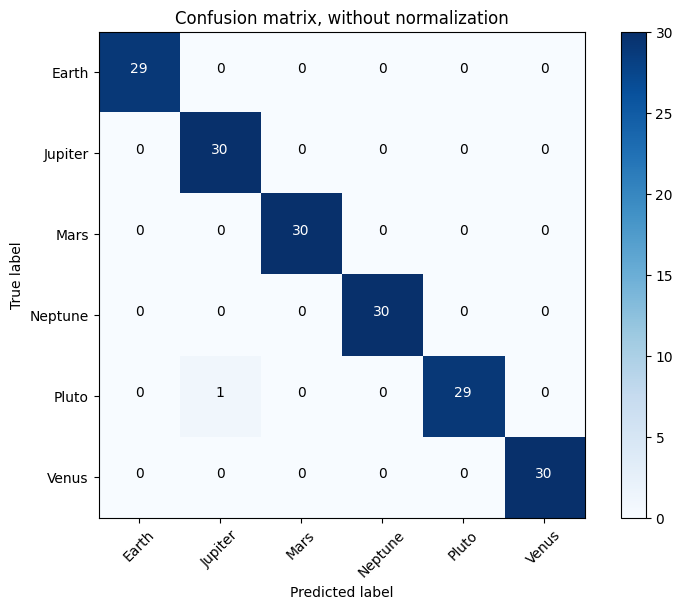

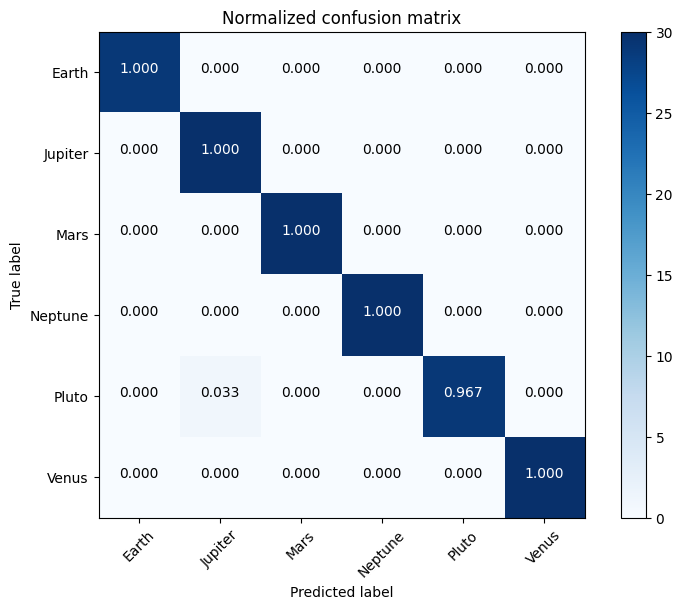

In [41]:
# Tracer la matrice de confusion non normalisée
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

le_for_class_names = LabelEncoder()
# Ajuster sur toutes les étiquettes originales (train + test) pour avoir toutes les classes uniques
le_for_class_names.fit(y_train_labels + y_test_labels)
class_names = list(le_for_class_names.classes_)

titles_options = [("Confusion matrix, without normalization", False),
                  ("Normalized confusion matrix", True)]

# Faire des prédictions en utilisant le classificateur entraîné 'clf' et les features du set de test
y_hat_encoded = clf.predict(X_test_features);

# La confusion_matrix attend les vraies étiquettes et les étiquettes prédites
# y_test_encoded contient les vraies étiquettes, encodées numériquement
# y_hat_encoded contient les étiquettes prédites, encodées numériquement par clf.predict
conf_mx = confusion_matrix(y_test_encoded, y_hat_encoded)

plt.figure(figsize=(10,6))
for title, normalize in titles_options:
    disp = plot_confusion_matrix(cm=conf_mx,
                                 target_names=class_names, # Use the actual class names
                                 title=title,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)

## 6.3. Affichage de la Précision et du Rappel (Precision & Recall)

In [42]:
# Faire des prédictions sur le set de test
y_pred_encoded = clf.predict(X_test_features)

class_names = label_encoder.classes_

# Générer et afficher le rapport de classification
__builtins__.print("Classification Report:")
__builtins__.print(classification_report(y_test_encoded, y_pred_encoded, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       Earth       1.00      1.00      1.00        29
     Jupiter       0.97      1.00      0.98        30
        Mars       1.00      1.00      1.00        30
     Neptune       1.00      1.00      1.00        30
       Pluto       1.00      0.97      0.98        30
       Venus       1.00      1.00      1.00        30

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179



## 6.4. Affichage de la courbe Précision-Rappel (Precision-Recall Curve)

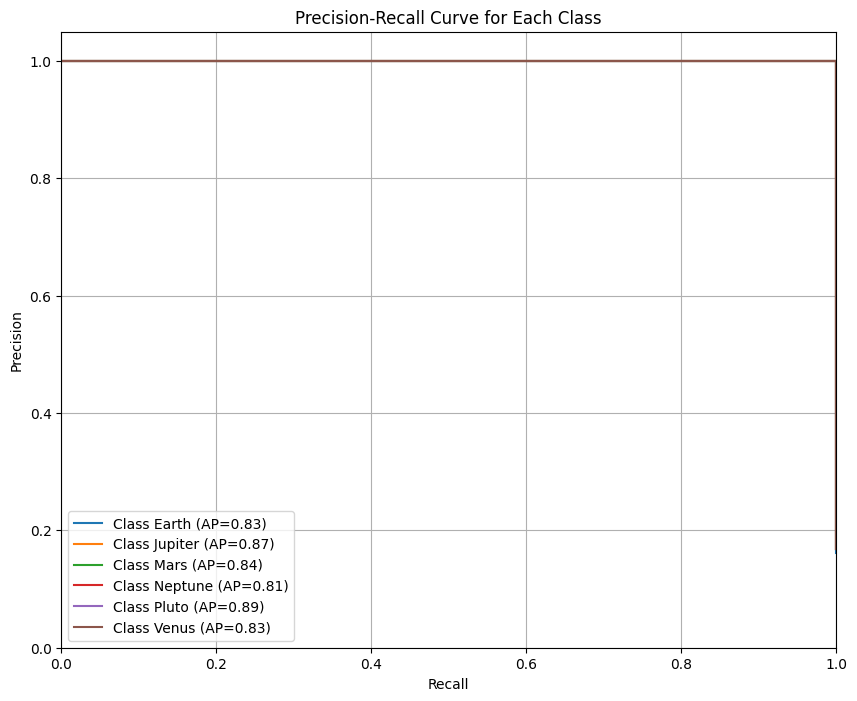

In [43]:
# Obtenir les probabilités de prédiction pour le set de test
y_pred_proba = clf.predict_proba(X_test_features)

binarizer = LabelBinarizer()
binarizer.fit(label_encoder.transform(label_encoder.classes_))
y_test_binarized = binarizer.transform(y_test_encoded)

class_names = label_encoder.classes_
n_classes = len(class_names)

# Tracer la courbe Précision-Rappel pour chaque classe
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    y_true_class = y_test_binarized[:, i]
    y_score_class = y_pred_proba[:, i]

    precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)

    plt.plot(recall, precision, label=f'Class {class_names[i]} (AP={np.mean(precision):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()